### 1. Importing Library

In [1]:
import pandas as pd
import numpy as np
import cv2 as cv
import os
import matplotlib.pyplot as plt

from tensorflow.keras import applications
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import img_to_array
import gc
from tensorflow.keras.models import Model

### 2. Data Loading and Data Preprocessing

In [2]:
train_dir = "../sign_data/train"
test_dir = "../sign_data/test"


In [3]:
# Check if directory is connected
# entries = os.listdir(train_dir)
# entry = os.listdir(os.path.join(train_dir, entries[0]))
# image = train_dir + '/' + entries[0] + '/' + entry[0]
# img = plt.imread(image)
# plt.imshow(img)

### 3. Create Training and Test Data

In [4]:
size = 224

In [5]:
train_data_names = []
test_data_names = []

# Train Data
train_data = []
train_labels = []

for data in os.listdir(train_dir):
    for datum in os.listdir(os.path.join(train_dir, data)):
        train_data_names.append(datum)
        image = train_dir + '/' + data + '/' + datum
        img = plt.imread(image)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.resize(img, (size, size))
        train_data.append([img])

        if data[-1]=='g':
            train_labels.append(np.array(1))
        else:
            train_labels.append(np.array(0))

train_data = np.array(train_data)/255.0
train_labels = np.array(train_labels)

# Test Data
test_data = []
test_labels = []

for data in os.listdir(test_dir):
    for datum in os.listdir(os.path.join(test_dir, data)):
        test_data_names.append(datum)
        image = test_dir + '/' + data + '/' + datum
        img = plt.imread(image)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.resize(img, (size, size))
        test_data.append([img])

        if data[-1]=='g':
            test_labels.append(np.array(1))
        else:
            test_labels.append(np.array(0))
        
test_data = np.array(test_data)/255.0
test_labels = np.array(test_labels)

In [6]:
# train_labels[1:1000]

In [7]:
from tensorflow.keras.utils import to_categorical
print(train_labels.shape)
train_labels = to_categorical(train_labels)
print(train_data.shape)
train_data = train_data.reshape(-1, size, size, 3)
test_data = test_data.reshape(-1, size, size, 3)
print(train_data.shape)
print(test_data.shape)

(1649,)
(1649, 1, 224, 224, 3)
(1649, 224, 224, 3)
(500, 224, 224, 3)


### 4. Feature Extraction

In [8]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights = 'imagenet', include_top = False, input_shape = (size, size, 3))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16_input (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 21137986 (80.64 MB)
Trainable params: 21137986 (80.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/6
19/19 [==

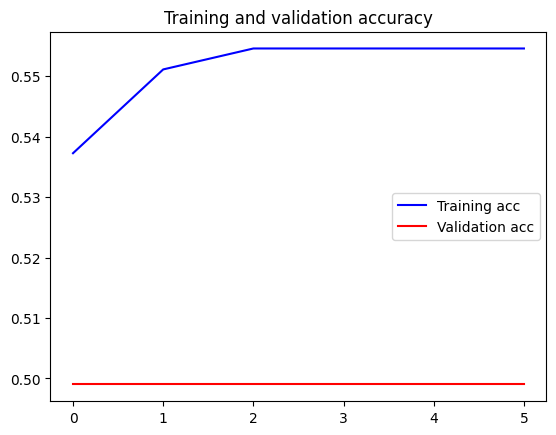

<Figure size 640x480 with 0 Axes>

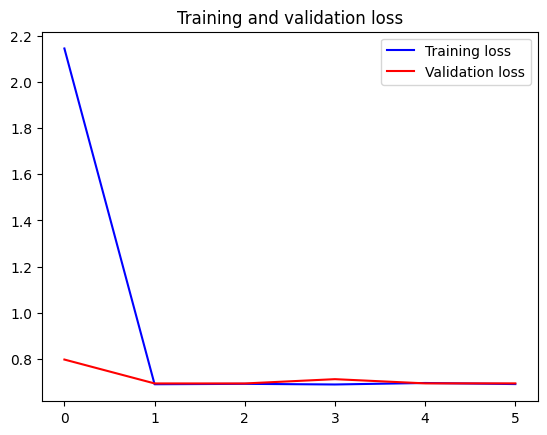

16/16 [==============================] - 180s 11s/step


In [9]:
model = Sequential()
data_augmentation = keras.Sequential([layers.experimental.preprocessing.RandomRotation(0.1)])
model.add(base_model)
model.add(Flatten(input_shape=base_model.output_shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

model = Model(inputs=model.input, outputs=model.output)
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])

model.summary()

earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1)

early_stop=[earlyStopping]
progess = model.fit(train_data,train_labels, batch_size=64,epochs=6, callbacks=early_stop,validation_split=.3)
acc = progess.history['accuracy']
val_acc = progess.history['val_accuracy']
loss = progess.history['loss']
val_loss = progess.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

intermediate_layer_model = Model(inputs=model.input, outputs=model.layers[-2].output)
intermediate_output_train = intermediate_layer_model.predict(train_data)
intermediate_output_test = intermediate_layer_model.predict(test_data)

np.save('./VGG16_Adam_train', intermediate_output_train)
np.save('./VGG16_Adam_test', intermediate_output_test)